# RSVQA high resolution


This page describes the usage of Dataloader and Datamodule for [the high resolution version of RSVQA](https://zenodo.org/record/6344367), a VQA dataset based on Sentinel-2 images over the Netherlands. It was first published by {cite:t}`rsvqa`. The dataset can be found on zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6344367.svg)](https://doi.org/10.5281/zenodo.6344367).
A small example of the data used is distributed with this package.

This module contains two `classes`, a standard `torch.util.data.Dataset` and a `pytorch_lightning.LightningDataModule` that encapsulates the `Dataset` for easy use in `pytorch_lightning` applications. Questions and Answers are read using JSON files.

In [1]:
# remove-input
# remove-output
import matplotlib.pyplot as plt
import pathlib
from pprint import pprint
import torch
from configilm.extra import data_dir

my_data_path = data_dir.mock_data_path["rsvqa-hr"]

/home/leonard/.cache/pypoetry/virtualenvs/configilm-l7TjLRMG-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## RSVQAHRDataSet

In its most basic form, the `Dataset` only needs the base path to the image and json files. The path should follow the same structure as it is when downloaded from the official zenodo page and extracted using the official website with images, questions and answer next to each other. The official naming for files is expected.

The full data path structure expected is
```
datapath = {
    "images": "/path/to/Images/Data",
    "train_data": "/path/to/jsons",
    "val_data": "/path/to/jsons",
    "test_data": "/path/to/jsons"
    "test_phili_data": "/path/to/jsons"
}
```
Note, that the keys have to match exactly while the paths can be selected freely.

In [2]:
# remove-output
from configilm import util
util.MESSAGE_LEVEL = util.MessageLevel.INFO  # use INFO to see all messages

from configilm.extra.DataSets import RSVQAHR_DataSet
 
ds = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path  # path to dataset
)

img, question, answer = ds[4]
img = img[:3] # only choose RGB channels

/home/leonard/Documents/development/ConfigILM/configilm/extra/DataSets/ClassificationVQADataset.py:144: UserWarning: No tokenizer was provided, using BertTokenizer (uncased). This may result in very bad performance if the used network expected other tokens
  warn(


       1,201 QA-pairs indexed
       1,201 QA-pairs used


Size: torch.Size([3, 256, 256])
Question: are there less buildings than large parkings?
Question (start): [101, 2024, 2045, 2625, 3121, 2084, 2312, 5581, 2015, 1029, 102, 0, 0, 0, 0]
Answer: no
Answer (start): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


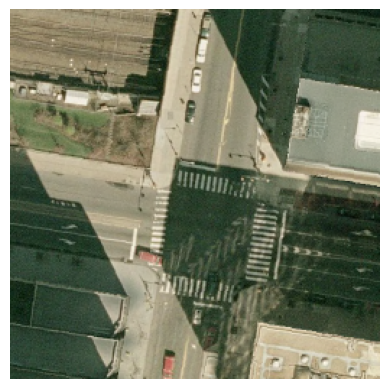

In [3]:
# remove-input
print(f"Size: {img.shape}")
print(f"Question: {ds.tokenizer.decode(question, skip_special_tokens=True)}")
print(f"Question (start): {question[:15]}")
answer_idx = int(torch.where(answer == 1)[0])
print(f"Answer: {ds.answers[answer_idx]}")
print(f"Answer (start): {answer[:15]}")

# for visualization, divide by largest value in image
img /= max(img.clone().flatten())
# and make it HWC instead of CHW())
img = img.permute(1, 2, 0)
_ = plt.imshow(img)
plt.axis('off')
plt.show()

### Tokenizer and Tokenization

As we can see, this Dataset uses a tokenizer to generate the Question out of a natural language text. If no tokenizer is provided, a default one will be used, however this may lead to bad performance if not accounted for. The tokenizer can be configured as input parameter.

In [4]:
# remove-output
from configilm.ConfigILM import _get_hf_model

tokenizer, _ = _get_hf_model("prajjwal1/bert-tiny")

ds = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    tokenizer=tokenizer
)
img, question, answer = ds[0]

       1,201 QA-pairs indexed
       1,201 QA-pairs used


:::{tip}
Usually this tokenizer is provided by the model itself as shown in the [VQA example](../../vqa.ipynb) during dataset creation.
:::

During tokenization a sequence of tokens (integers) of specific length is generated. The length of this sequence can be set with the parameter `seq_length`. If the generated tokens are shorter than the sequence length, the sequence will be padded with zeros. If it is longer, the sequence is truncated.
:::{note}
Most tokenizer use an 'End of Sequence' token that will always be the last one in the non-padded sequence.
:::

In [5]:
# remove-output
ds = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    tokenizer=tokenizer,
    seq_length=16
)
_, question1, _ = ds[0]
print(question1)

       1,201 QA-pairs indexed
       1,201 QA-pairs used
[101, 2024, 2045, 2625, 3121, 2012, 1996, 2327, 1997, 1996, 7027, 2181, 2084, 3121, 1999, 102]


In [6]:
# remove-input
print(question1)

[101, 2024, 2045, 2625, 3121, 2012, 1996, 2327, 1997, 1996, 7027, 2181, 2084, 3121, 1999, 102]


In [7]:
# remove-output
ds = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    tokenizer=tokenizer,
    seq_length=8
)
_, question2, _ = ds[0]
print(question2)

       1,201 QA-pairs indexed
       1,201 QA-pairs used
[101, 2024, 2045, 2625, 3121, 2012, 1996, 102]


In [8]:
# remove-input
print(question2)

[101, 2024, 2045, 2625, 3121, 2012, 1996, 102]


The tokenizer can also be used to reconstruct the input/question from the IDs including the special tokens:

In [9]:
print(f"Question 1: '{tokenizer.decode(question1)}'")
print(f"Question 2: '{tokenizer.decode(question2)}'")

Question 1: '[CLS] are there less buildings at the top of the retail area than buildings in [SEP]'
Question 2: '[CLS] are there less buildings at the [SEP]'


or without:

In [10]:
print(f"Question 1: '{tokenizer.decode(question1, skip_special_tokens=True)}'")
print(f"Question 2: '{tokenizer.decode(question2, skip_special_tokens=True)}'")

Question 1: 'are there less buildings at the top of the retail area than buildings in'
Question 2: 'are there less buildings at the'


### Selecting Bands
Like for the {{ben}} DataSet, this DataSet supports different Band combinations. Currently, the selection is limited to some preconfigured combinations. Which bands are used is defined by the number of channels set in the Dataset. The selection can be seen when we use a faulty configuration.

In [11]:
# hide-output
try:
    ds = RSVQAHR_DataSet.RSVQAHRDataSet(
        data_dirs=my_data_path,  # path to dataset
        img_size=(-1, 120, 120)
    )
except AssertionError as a:
    print(a)

RSVQA-HR only supports RGB images.


### Splits

It is possible to load only a specific split (`'train'`, `'val'`, `'test'` or `'test_phili'`) in the dataset. . The images loaded are specified using the json files in the specified path. By default (`None`), all four are loaded into the same `Dataset`.

In [12]:
# remove-output
_ = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    split="test",
    tokenizer=tokenizer
)

         300 QA-pairs indexed
         300 QA-pairs used


### Restricting the number of loaded images

It is also possible to restrict the number of images indexed. By setting `max_img_idx = n` only the first `n` images (in alphabetical order based on their S2-name) will be loaded. A `max_img_idx` of  `None`, `-1` or larger than the number of images in the csv file(s) (in this case 25) equals to load-all-images behaviour.

In [13]:
# hide-output
_ = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    max_len=10,
    tokenizer=tokenizer
)

       1,201 QA-pairs indexed
          10 QA-pairs used


In [14]:
# hide-output
_ = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    max_len=100,
    tokenizer=tokenizer
)

       1,201 QA-pairs indexed
         100 QA-pairs used


### Select Number of Classes or specific Answers

For some applications, it is relevant to have only a certain number of classes as valid output. To prevent a dimension explosion if there are too many possible classes, the number of classes can be limited. For the 'train' split, it is then automatically determined which combination of classes results in the highest reduction of the dataset.

In [15]:
# hide-output
train_ds = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    split="train",
    tokenizer=tokenizer,
    num_classes=3
)

         400 QA-pairs indexed
         400 QA-pairs used


These selected answers can be re-used in other splits or limited if only a subset is required.

:::{note}
The number of classes does not necessarily match the number of answers. If there are fewer answers then classes, the last classes will never be encoded in the one-hot encoded answer vector. If there are more, an `IndexError` will happen during accessing a non encode-able element.
:::

In [16]:
# remove-output
print(f"Train DS: {train_ds.answers}")

ds = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer,
    selected_answers=train_ds.answers
)
print(f"Val DS 1: {ds.answers}")

ds = RSVQAHR_DataSet.RSVQAHRDataSet(
    data_dirs=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer,
    selected_answers=train_ds.answers[:2],
)
print(f"Val DS 2: {ds.answers}")

Train DS: ['6', '8', 'between 11m2 and 100m2']
         300 QA-pairs indexed
         300 QA-pairs used
Val DS 1: ['6', '8', 'between 11m2 and 100m2']
         300 QA-pairs indexed
         300 QA-pairs used
Val DS 2: ['6', '8']


In [17]:
# remove-input
print(f"Train DS: {train_ds.answers}")
print(f"Val DS 1: {ds.answers}")
print(f"Val DS 2: {ds.answers}")

Train DS: ['6', '8', 'between 11m2 and 100m2']
Val DS 1: ['6', '8']
Val DS 2: ['6', '8']


## RSVQAHRDataModule

This class is a Lightning Data Module, that wraps the RSVQAHRDataSet. It automatically generates DataLoader per split with augmentations, shuffling, etc., depending on the split. All images are resized and normalized and images in the train set additionally basic-augmented via noise and flipping/rotation. The train split is also shuffled, however this can be overwritten (see below).
To use a DataModule, the setup() function has to be called. This populates the Dataset splits inside the DataModule. Depending on the stage ('fit', 'test' or None), the setup will prepare only train & validation Dataset, only test Dataset or all three.

In [18]:
# remove-output
from configilm.extra.DataModules import RSVQAHR_DataModule

dm = RSVQAHR_DataModule.RSVQAHRDataModule(
    data_dirs=my_data_path  # path to dataset
)

In [19]:
print("Before:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

Before:
None
None
None


In [20]:
# remove-output
dm.setup(stage="fit")

         400 QA-pairs indexed
         400 QA-pairs used
         300 QA-pairs indexed
         300 QA-pairs used
  Total training samples:      400  Total validation samples:      300


/home/leonard/Documents/development/ConfigILM/configilm/extra/DataSets/ClassificationVQADataset.py:144: UserWarning: No tokenizer was provided, using BertTokenizer (uncased). This may result in very bad performance if the used network expected other tokens
  warn(


In [21]:
print("After:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

After:
None


Afterwards the pytorch `DataLoader` can be easily accessed. Note, that $len(DL) = \lceil \frac{len(DS)}{batch\_size} \rceil$, therefore here with the default `batch_size` of 16: 25/16 -> 2.

In [22]:
train_loader = dm.train_dataloader()
print(len(train_loader))

25


The `DataModule` has in addition to the `DataLoader` settings a parameter each for `data_dir`, `image_size` and `max_img_idx` which are passed through to the `DataSet`.

### DataLoader settings

The `DataLoader` have four settable parameters: `batch_size`, `num_workers_dataloader`, `shuffle` and `pin_memory` with 16, `os.cpu_count()` / 2, `None` and `None` as their default values.

A shuffle of `None` means, that the train set is shuffled but validation and test are not.
Pinned Memory will be set if a `CUDA` device is found, otherwise it will be of. However, this behaviour can be overwritten with `pin_memory`. Changing some of these settings will be accompanied by a Message-Hint printed.

In [23]:
# remove-output
dm = RSVQAHR_DataModule.RSVQAHRDataModule(
    data_dirs=my_data_path,  # path to dataset
    batch_size=4,
    tokenizer=tokenizer
)
dm.setup(stage="fit")

         400 QA-pairs indexed
         400 QA-pairs used
         300 QA-pairs indexed
         300 QA-pairs used
  Total training samples:      400  Total validation samples:      300


In [24]:
print(len(dm.train_dataloader()))

100


In [25]:
# hide-output
_ = RSVQAHR_DataModule.RSVQAHRDataModule(
    data_dirs=my_data_path,  # path to dataset
    shuffle=False
)

/home/leonard/Documents/development/ConfigILM/configilm/extra/DataModules/ClassificationVQADataModule.py:109: UserWarning: Shuffle was set to False. This is not recommended for most configuration. Use shuffle=None (default) for recommended configuration.
  warn(


In [26]:
# hide-output
_ = RSVQAHR_DataModule.RSVQAHRDataModule(
    data_dirs=my_data_path,  # path to dataset
    num_workers_dataloader=2
)

In [27]:
# hide-output
_ = RSVQAHR_DataModule.RSVQAHRDataModule(
    data_dirs=my_data_path,  # path to dataset
    pin_memory=False
)

### Different Test split
As the original `DataSet` contains different test splits (_Test Set 1_ is from the same data source as training and validation, _Test Set 2_ is from Philadelphia and a different distribution), a switch was added to the `DataModule` to decide which one to use at test time. By default, _Test Set 1_ (`"test"` in the DataSet) is used.

In [28]:
# hide-output
dm = RSVQAHR_DataModule.RSVQAHRDataModule(
    data_dirs=my_data_path,  # path to dataset
    batch_size=4,
    tokenizer=tokenizer,
    use_phili_test=False
)
dm.setup(stage="test")

         300 QA-pairs indexed
         300 QA-pairs used
  Total test samples:      300


In [29]:
# hide-output
dm = RSVQAHR_DataModule.RSVQAHRDataModule(
    data_dirs=my_data_path,  # path to dataset
    batch_size=4,
    tokenizer=tokenizer,
    use_phili_test=True
)
dm.setup(stage="test")

         201 QA-pairs indexed
         201 QA-pairs used
  Total test samples:      201
